In [1]:
from sklearn.model_selection import KFold
import json

with open("./data/pig/train/annotations/train.json") as f:
    anno = json.load(f)
anno["annotations"] = [
    dict(list(_.items()) + [("id", str(i))]) if "id" not in _ else 
    dict(list(_.items()) + [("iscrowd", 0)]) if "iscrowd" not in _ else 
    dict(list(_.items()) + [("area", _["bbox"][-1] * _["bbox"][-2])]) if "area" not in _ else 
    dict(list(_.items()) + [("segment", [])]) if "segment" not in _ else 
    _ for i, _ in enumerate(anno["annotations"])]
with open("./data/pig/train/annotations/train.json", "w") as f:
    json.dump(anno, f)

In [2]:
split = KFold(4)

for fold, (train_idx, valid_idx) in enumerate(split.split(anno["images"])):
    train_ids = set([_["id"] for i, _ in enumerate(anno["images"]) if i in train_idx])
    valid_ids = set([_["id"] for i, _ in enumerate(anno["images"]) if i in valid_idx])

    train_json = {
        "images": [_ for _ in anno["images"] if _["id"] in train_ids],
        "annotations": [_ for _ in anno["annotations"] if _["image_id"] in train_ids],
        "categories": [_ for _ in anno["categories"]]
    }
    valid_json = {
        "images": [_ for _ in anno["images"] if _["id"] in valid_ids],
        "annotations": [_ for _ in anno["annotations"] if _["image_id"] in valid_ids],
        "categories": [_ for _ in anno["categories"]]
    }
    with open(f"./data/pig/train/jsons/train_fold_{fold}.json", "w") as f:
        json.dump(train_json, f)
    with open(f"./data/pig/train/jsons/valid_fold_{fold}.json", "w") as f:
        json.dump(valid_json, f)

loading annotations into memory...
Done (t=0.07s)
creating index...
index created!


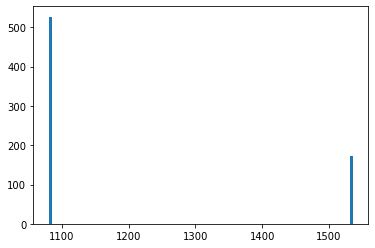

In [4]:
from pycocotools.coco import COCO
import matplotlib.pyplot as plt
from PIL import Image
import cv2


gt = COCO("./data/pig/train/jsons/valid_fold_0.json")
dt = gt.loadRes("./work_dirs/pig/config_detectors_50_gc/valid.bbox.json")

img_id = list(gt.imgs)[0]
img = cv2.


-- valid.bbox --

bbox AP @ 50: 98.97

                         Main Errors
  Type      Cls      Loc     Both     Dupe      Bkg     Miss  
-------------------------------------------------------------
   dAP     0.00     0.04     0.00     0.00     0.00     0.00  

                        Main Per Class Errors
  class   Type      Cls      Loc     Both     Dupe      Bkg     Miss  
---------------------------------------------------------------------
    pig    dAP     0.00     0.04     0.00     0.00     0.00     0.00  

        Special Error
  Type   FalsePos   FalseNeg  
-----------------------------
   dAP       0.04       0.31  



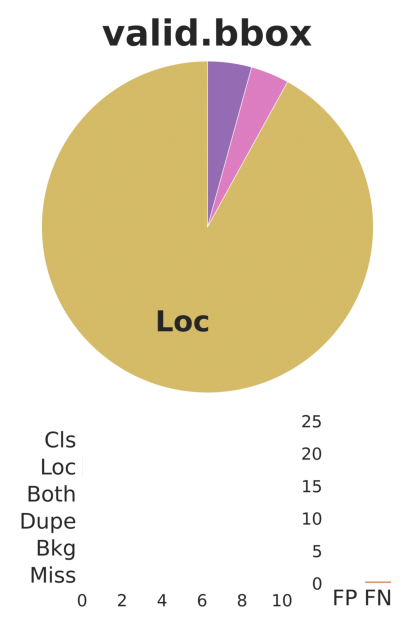

In [1]:
from tidecv import TIDE, datasets

tide = TIDE()
tide.evaluate(datasets.COCO("./data/pig/train/jsons/valid_fold_0.json"), datasets.COCOResult("./work_dirs/pig/config_detectors_50_gc/valid.bbox.json"), mode=TIDE.BOX, pos_threshold = 0.5)
tide.summarize()
tide.plot()

In [1]:
import json

with open("./data/rich/test_A/annotations/test.json") as f:
    ann = json.load(f)

with open("./work_dirs/config_detectors_50_gc_all_swa/test.bbox.json") as f:
    det = json.load(f)

ann["annotations"] = det
with open("./submission.json", "w") as f:
    json.dump(ann, f)

In [18]:
import json
import numpy as np
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

gt = COCO("./data/check/test_A/annotations/test.json")
dt = gt.loadRes("./work_dirs/check/config_detectors_50_gc/test.bbox.json")
# gt = COCO("./data/check/train/jsons/valid_fold_0.json")
# dt = gt.loadRes("./work_dirs/check/config_detectors_50_gc/valid.bbox.json")
# ev = COCOeval(gt, dt, "bbox")

# aps = []
# for cat_id in sorted(gt.cats.keys()):
#     ev.params.catIds = [cat_id]
#     ev.evaluate()
#     ev.accumulate()
#     ev.summarize()
#     aps.append(ev.stats[1])
# print((sum(aps[:6]) + sum(aps[-6:]) * 0.7) / (6 + 6 * 0.7))

res = []
for img_id in sorted(gt.imgs.keys()):
    res.append([])
    for cat_id in sorted(gt.cats.keys()):
        res[-1].append([])
        anns = [dt.anns[ann_id] for ann_id in dt.getAnnIds(imgIds = [img_id], catIds = [cat_id])]
        anns = sorted(anns, key = lambda x: -x["score"])
        for ann in anns:
            x, y, w, h = ann["bbox"]
            s = ann["score"]
            if s < 0.001:
                continue
            res[-1][-1].append([x, y, x + w, y + h, s])
with open("submission.json", "w") as f:
    json.dump(res, f, indent=4, separators=(',', ': ') )

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=2.34s)
creating index...
index created!


In [12]:
import json
import numpy as np
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

gt = COCO("./data/pig/test_A/annotations/test.json")
dt = gt.loadRes("./work_dirs/pig/config_detectors_50_gc/test.bbox.json")

cnts = ''
for img_id in sorted(gt.imgs):
    res = ''
    file_name = gt.imgs[img_id]['file_name']
    cnt = 0
    for ann_id in dt.getAnnIds(imgIds = [img_id]):
        ann = dt.anns[ann_id]
        x, y, w, h = ann['bbox']
        s = ann['score']
        if s > 0.6:
            cnt += 1
        res += f'pig {s} {x + w / 2} {y + h / 2} {w} {h}\n'
    with open(f"./data/pig/test_A/det_results/{file_name[:-4]}.txt", 'w') as f:
        f.write(res)
    cnts += f'{file_name} 0\n'
with open("./data/pig/test_A/pig_count.txt", 'w') as f:
    f.write(cnts)


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.12s)
creating index...
index created!


In [6]:
ann

{'image_id': 'd6_1597277880_img_1',
 'bbox': [665.603271484375,
  674.6018676757812,
  303.053955078125,
  178.83209228515625],
 'score': 0.9997984766960144,
 'category_id': 1,
 'segmentation': [[665.603271484375,
   674.6018676757812,
   665.603271484375,
   853.4339599609375,
   968.6572265625,
   853.4339599609375,
   968.6572265625,
   674.6018676757812]],
 'area': 54195.77286191285,
 'id': 1,
 'iscrowd': 0}